# 심층 신경망 훈련하기

### 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 그래디언트 소실과 폭주 문제

In [2]:
# 로지스틱 활성화 함수 정의
def logit(z):
    return 1 / (1 + np.exp(-z))

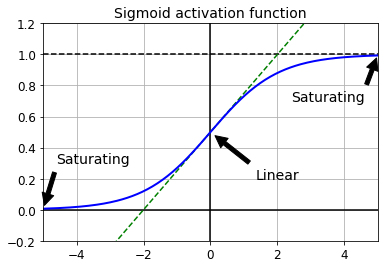

In [3]:
# 로지스틱 활성화 함수의 수렴
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Xavier 초기화와 He 초기화

In [4]:
# keras에 존재하는 초기화 전략(글로럿, 르쿤, He 등)
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
# 기본적으로 균등분포의 글로럿 초기화 사용 -> 층을 만들 때 he_uniform, he_normal 등으로로 변경 가능
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
# fan_in 대신 fan_out 기반의 균등분포 He 초기화 사용하고 싶은 경우 Variance Scaling 사용
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')

keras.layers.Dense(10, activation="relu", kernel_initializer=init)

### 수렴하지 않는 활성화 함수

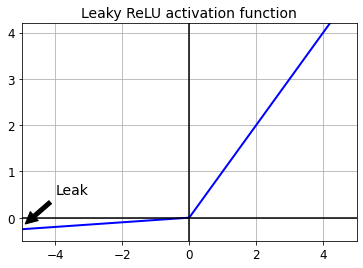

In [7]:
# Leakly ReLU : ReLU와 비슷하나 음수 부분이 작은 기울기 가짐

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [8]:
# keras 활성화 함수 
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [9]:
# ReLU 계열 함수
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

### LeakyReLU를 사용해 MNIST 신경망 훈련

In [10]:
# MNIST 데이터 로드
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [11]:
# Leaky ReLU 활성화 층을 적용하려는 모델뒤에 추가
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5339 - accuracy: 0.8223 - val_loss: 0.5156 - val_accuracy:

In [12]:
# PReLU를 이용해 테스트

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

### ELU

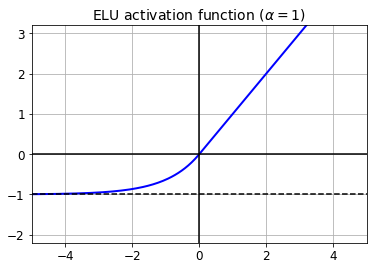

In [13]:
# ELU 활성화 함수
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)
    
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [14]:
# ELU 함수 레이어에 추가
keras.layers.Dense(10, activation="elu")

### SELU

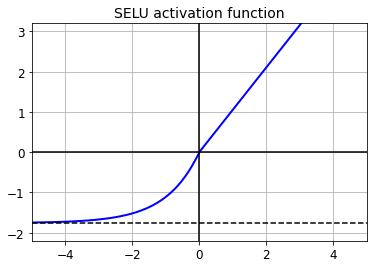

In [15]:
# SELU 활성화 함수
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [16]:
# 각 뉴런의 평균 출력이 0, 표준 편차는 1에 가깝도록 조정 -> 그래디언트 소실 문제 최소화
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [17]:
# SELU 함수 레이어에 추가
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [18]:
# 100개의 은닉층과 SELU 활성화 함수를 사용한 MNIST 신경망 훈련
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
# 입력을 평균 0과 표준편차 1로 변경 필수
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 18ms/step - loss: 1.3776 - accuracy: 0.4540 - val_loss: 1.1731 - val_accuracy: 0.5614
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.9138 - accuracy: 0.6665 - val_loss: 0.7028 - val_accuracy: 0.7484
Epoch 3/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6962 - accuracy: 0.7481 - val_loss: 0.6540 - val_accuracy: 0.7546
Epoch 4/5
1719/1719 [==============================] - 30s 18ms/step - loss: 0.6539 - accuracy: 0.7676 - val_loss: 0.5557 - val_accuracy: 0.7978
Epoch 5/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.5582 - accuracy: 0.7990 - val_loss: 0.5703 - val_accuracy: 0.8016


In [20]:
# SELU 아닌 ReLU 활성화 함수 사용 했을 시
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
1719/1719 [==============================] - 31s 16ms/step - loss: 1.8261 - accuracy: 0.2616 - val_loss: 1.3347 - val_accuracy: 0.3894
Epoch 2/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.1959 - accuracy: 0.4908 - val_loss: 0.9373 - val_accuracy: 0.5902
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.9600 - accuracy: 0.6118 - val_loss: 0.9026 - val_accuracy: 0.5906
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.8231 - accuracy: 0.6759 - val_loss: 0.7320 - val_accuracy: 0.7290
Epoch 5/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.7360 - accuracy: 0.7171 - val_loss: 0.7823 - val_accuracy: 0.7108


### 배치 정규화

In [22]:
# 은닉층 사이에 배치 정규화 층 적용
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_217 (Dense)            (None, 10)               

In [23]:
# 첫번째 배치 정규화 층의 파라미터
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

In [25]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [26]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 0.8491 - accuracy: 0.7130 - val_loss: 0.5606 - val_accuracy: 0.8086
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5753 - accuracy: 0.8007 - val_loss: 0.4785 - val_accuracy: 0.8368
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5182 - accuracy: 0.8194 - val_loss: 0.4432 - val_accuracy: 0.8466
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4800 - accuracy: 0.8332 - val_loss: 0.4211 - val_accuracy: 0.8526
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4546 - accuracy: 0.8405 - val_loss: 0.4058 - val_accuracy: 0.8592
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4393 - accuracy: 0.8461 - val_loss: 0.3947 - val_accuracy: 0.8604
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4233 - accuracy: 0.8523 - val_loss: 0.3833 - val_ac

In [27]:
# 활성화 함수 전에 배치 정규화 하는 경우
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 1.0640 - accuracy: 0.6715 - val_loss: 0.6875 - val_accuracy: 0.7836
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6903 - accuracy: 0.7787 - val_loss: 0.5609 - val_accuracy: 0.8174
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6036 - accuracy: 0.8014 - val_loss: 0.5030 - val_accuracy: 0.8372
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5514 - accuracy: 0.8164 - val_loss: 0.4674 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5163 - accuracy: 0.8260 - val_loss: 0.4431 - val_accuracy: 0.8520
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4950 - accuracy: 0.8308 - val_loss: 0.4254 - val_accuracy: 0.8580
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4762 - accuracy: 0.8364 - val_loss: 0.4115 - val_ac